## This notebook simulates a cantilever beam

In [1]:
import math
import time
import cProfile
import pdb as pdb 
import numpy as np
import scipy as sc
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import MBstructs as MBS
import MBfuncts as MBF
import DCA

from IPython.display import display
from __future__ import division
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
np.set_printoptions(precision=4,suppress=True)

In [2]:
def myRK4(func, state0, tspan, *args):
    """
    Inputs:
        func - function that returns the derivatives of the state variables
          x0 - starting conditions
           t - array of time values 
   Outputs:
       w - approximate solution at the mesh-points (time-steps)
    """
    dt = np.max(np.diff(tspan))
    nsteps = len(tspan)
    state = np.zeros((nsteps-1,len(state0)))
    state = np.vstack((state0,state))
        
    for i in range(len(tspan)-1):
        k1 = dt*func(state[i,:],        tspan,*args)
        k2 = dt*func(state[i,:] + k1/2, tspan,*args)
        k3 = dt*func(state[i,:] + k2/2, tspan,*args)
        k4 = dt*func(state[i,:] + k3,   tspan,*args)
        
        state[i+1,:] = state[i,:] + (1/6*((k1)+(2*k2)+(2*k3)+(k4))).reshape(1,len(state0))
    return state

In [3]:
def simulate(state,tspan,bodiesGEBF,bodiesRigid,joints,BC1,BC2):
    '''
    This function extracts the generalized coordinates from the solution 
    of the equations of motion after calling the DCA to solve the equations of motion 
    '''
    
    nGEBF = len(bodiesGEBF)
    nRIGID = len(bodiesRigid)
    
    # only pin joints connecting rigid bodies
    q = state[:nRIGID*ndofsRigid + nGEBF*ndofsGEBF]
    u = state[nRIGID*ndofsRigid + nGEBF*ndofsGEBF:]
    
    # slice out rigid generalized coordinates and speeds from GEBF
    qRigid = q[:nRIGID*ndofsRigid]
    uRigid = u[:nRIGID*ndofsRigid]
    qGEBF  = q[nRIGID*ndofsRigid:]
    uGEBF  = u[nRIGID*ndofsRigid:]
    
    # Update the Kinematics 2D n-link Pendulum
    # Now that these functions "woe
    # This should be a class function for each body type not an absolute function
    # e.g., [body.updateKin for body in bodies]
        
    MBF.kinematics_Rigid2D(bodiesRigid,qRigid,uRigid)  
    MBF.kinematics_GEBF2D(bodiesGEBF,qGEBF,uGEBF)
    
    # slice out generalized cooridnates
    # and make a sublist for each body
    # these u's are not generalized speeds these are the displacements of the nodes
    u = qGEBF.tolist()
    u = [u[i*ndofsGEBF:(i*ndofsGEBF)+ndofsGEBF] for i in range((int(len(u)/ndofsGEBF)))]

    # 'pop' off the rotational coordinates 
    # those are dealt with through the 'kinematic' sweep
    for ue in u:
        ue.pop(3)
        ue.pop(0)
        
    # compute the inverse inertial properties of the body 
    # with the updated generalized speeds
    for body,ue in zip(bodiesGEBF,u):
        body.intProps('gebf',ue)

    for body in bodiesRigid:
        body.intProps('rigid')

    # join the lists of bodies for a total list 
    # order matters
    bodies = bodiesRigid + bodiesGEBF
    
    # Call the Recursive DCA Algorithm
    # This returns a list of the form:
    # [A11,A12,A21,A22,...,An1,An2]
    # where Axy corresponds to the acceleration
    # of the yth handle of the xth body
    accel = DCA.solve(nbodies,0,bodies,joints,BC1,BC2)
    
    accelRigid = accel[:2*len(bodiesRigid)]
    accelGEBF  = accel[2*len(bodiesRigid):]

    # compute the generalized accelerations for kinematic joints
    udot_Rigid = MBF.get_gen_accel_Rigid(nRIGID, joints, accelRigid)
    udot_GEBF  = MBF.get_gen_accel_GEBF(nGEBF, accelGEBF)
    udot = np.hstack((udot_Rigid,udot_GEBF))

    state_dot = np.hstack((state[nRIGID*ndofsRigid + nGEBF*ndofsGEBF:],udot))
    return state_dot

### Simulation Specifications

In [4]:
# number of bodies and GEBF elements and kinematic joints
# *** NOTE: For testing pupposes DCA does NOT effectively work for one body
#          - For one body DCA returns [A1 F1c A2 F2c]
#          - For two or more bodies DCA returns [A1 A2] ***
nRIGID = 4
nGEBF  = 0
nbodies = nGEBF + nRIGID

nJpin = 4
nJfixed = 0

ndofsGEBF = 6   # (x,y,theta per joint)
ndofsRigid  = 1 # (one pin joint)

# GEBF-Properties
# Physical Properties
A   =  0.0018
I   =  1.215e-8
L   =  1.2
r   =  math.sqrt(A/math.pi)
l = 0.12

# Material Properties
E   =  0.7e6
rho =  5540

# Length of time of the simulation and time-step
t_final = 5
dt = 0.01
tspan = np.arange(0,t_final,dt)

### Initilization

In [5]:
# Create a list of Joints
jointsPin = [MBS.Joint('revolute2D') for i in range(nJpin)]
jointsFixed = [MBS.Joint('fixed') for i in range (nJfixed)]
joints = jointsPin + jointsFixed

# Create a the list of bodies 
bodiesGEBF = [MBS.Body() for i in range(nGEBF)]
bodiesRigid = [MBS.Body() for i in range(nRIGID)]
for body in bodiesGEBF:
    body.initialize('gebf', E, A, I, r, rho, l)
for body in bodiesRigid:
    body.initialize('rigid', 1.0,1.0,1.0)
    
# start the rope from the horizontal qi = 0 for ALL i

# sublists handy for initilization of bodies 
q0GEBF = [[0 for i in range(ndofsGEBF)] for i in range(nGEBF)]
u0GEBF = [[0 for i in range(ndofsGEBF)] for i in range(nGEBF)]

# All rigid bodies are connected by pin joints
q0Rigid = [[0 for i in range(ndofsRigid)] for i in range(nRIGID)]
u0Rigid = [[0 for i in range(ndofsRigid)] for i in range(nRIGID)]

q0 = q0Rigid + q0GEBF
u0 = u0Rigid + u0GEBF

# flatten sub-lists into a single state vector
q0 = np.array([q for q_body in q0 for q in q_body],dtype=np.double).squeeze()
u0 = np.array([u for u_body in u0 for u in u_body],dtype=np.double).squeeze()

state0 = np.hstack((q0,u0))

In [6]:
state =  myRK4(simulate,state0,tspan, bodiesGEBF,bodiesRigid,joints,2,1)
# state = odeint(simulate,state0,tspan,(bodiesGEBF,bodiesRigid,joints,2,1))

In [7]:
q = state[:,:nRIGID*ndofsRigid + nGEBF*ndofsGEBF]
u = state[:,nRIGID*ndofsRigid + nGEBF*ndofsGEBF:]

# slice out rigid generalized coordinates and speeds from GEBF
qRigid = q[:,:nRIGID*ndofsRigid]
uRigid = u[:,:nRIGID*ndofsRigid]
qGEBF  = q[:,nRIGID*ndofsRigid:]
uGEBF  = u[:,nRIGID*ndofsRigid:]

# x,y = get_topology_2DRigid(qRigid)
r0 = np.array([[l*i, 0, l*(i+1), 0] 
               for i in range(nGEBF)],dtype=np.double).reshape(1,ndofsGEBF*nGEBF - 2*nGEBF)

# Interpolate between nodes with npoints, and compute absolute positions of nodes for plotting
# npoints = 10
# x,y = MBF.get_topology_2DGEBF(qGEBF, r0, nGEBF, npoints)

In [8]:
ke,pe,te = MBF.get_energy_Rigid(bodiesRigid,state)

In [9]:
x,y = MBF.get_topology_2DRigid(qRigid,l)

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-(nbodies+1)*l,(nbodies+1)*l), 
                                              ylim=(-(nbodies+1)*l,(nbodies+1)*l))
# ax = fig.add_subplot(111, autoscale_on=False, xlim=(-100,100), 
#                                               ylim=(-100,100))

ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %0.4fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
#     thisx = [0, x[i][1], x[i][2]]
#     thisy = [0, y[i][1], y[i][2]]
    thisx = x[i]
    thisy = y[i]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template%(i*dt))
    return line, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
    interval = 1, blit=False, init_func=init)

#ani.save('double_pendulum.mp4', fps=15)
plt.show()

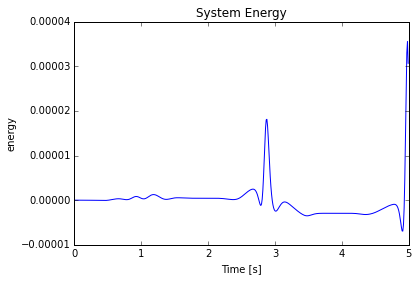

<function matplotlib.pyplot.show>

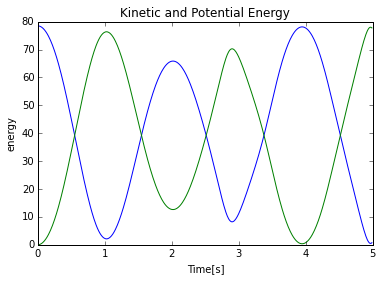

In [11]:
# The energy of the system is calculated and plotted
%matplotlib inline 
plt.plot(tspan,te-te[0])
plt.xlabel("Time [s]")
plt.ylabel("energy")
plt.title("System Energy")
plt.show()

plt.plot(tspan,pe,tspan,ke)
plt.xlabel("Time[s]")
plt.ylabel("energy")
plt.title("Kinetic and Potential Energy")
plt.show

In [12]:
%qtconsole